In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hcipy import *

In [2]:
# Set up grids
# wvl = 1e-6
# fno = 30
# pupil_grid = make_pupil_grid(2048,30)
# focal_grid = make_focal_grid(q=4,num_airy=120,spatial_resolution=wvl*fno)

# # Entrance pupil
# gmt = evaluate_supersampled(make_gmt_aperture(normalized=False),pupil_grid,4)
# gmtfield = Wavefront(gmt,wvl)
# imshow_field(gmtfield.intensity)

In [33]:
class DummyRayfront:
    def __init__(self,jones_pupil):
        self.jones_pupil = jones_pupil

class Instrument:
    def __init__(self,aperture,Rayfront,coronagraph='Ideal',wavelength=1e-6,npix_pupil=1024,pupil_diameter=50.8e-3,q_focal=4,nairy_focal=8,*coro_args,**coro_kwargs):
        """creates a high-contrast imaging instrumnet using the HCIPy optical propagation package for diffraction and poke to generate jones pupils
        This object is tailored to the GSMT's, so functionality is restricted to these models.

        Parameters
        ----------
        aperture : str
            'ELT', 'TMT', or 'GMT'
        coronagraph : str, optional
            'VVC', 'APLC', or 'Ideal'. by default Ideal, which uses the PerfectCoronagraphs
        Rayfront : poke.Rayfront
            Rayfront object from poke used to create the Jones Pupils. Must have the raytrace done
        wavelength : float, optional
            wavelength of light, by default 1 to maintain units of lambda/D
        npix_pupil : int, optional
            number of samples across the pupil, by default 1024
        pupil_diameter : float, optional
            Diameter of the pupil in meters, by default 1 to maintain units of lambda/D
        q_focal : int, optional
            Number of samples per lambda/D, by default 8
        nairy_focal : int, optional
            number of lambda/D across the FoV of the focal grid, by default 10
        """

        # load basic parameters
        self.wavelength = wavelength
        self.npix_pupil = npix_pupil
        self.pupil_diameter = pupil_diameter
        self.q = q_focal
        self.nairy = nairy_focal

        # load jones pupil
        self.jones_pupil = Rayfront.jones_pupil # This assumes data on a square grid

        # configure grids for focusing
        self.pupil_grid = make_pupil_grid(self.npix_pupil,self.pupil_diameter)
        self.focal_grid = make_focal_grid(self.q,self.nairy)

        # configure fraunhofer propagator for pupil-to-focus propagation
        self.pupil_to_focus = FraunhoferPropagator(self.pupil_grid,self.focal_grid) # .forward() and .reverse() work

        # configure fresnel propagation for plane-to-plane
        self.plane_to_plane = FresnelPropagator(self.pupil_grid,pupil_diameter*10*2) # F/10 OAPs, 4f system

        # set up deformable mirror
        num_actuators_across = 32
        actuator_spacing = 1.05 / 32 * self.pupil_diameter
        aberration_ptv = 0.02 * self.wavelength # m
        influence_functions = make_gaussian_influence_functions(self.pupil_grid, num_actuators_across, actuator_spacing)
        self.deformable_mirror = DeformableMirror(influence_functions)

        # make surface aberrations
        tip_tilt = make_zernike_basis(3, self.pupil_diameter, self.pupil_grid, starting_mode=2)
        self.aberration = SurfaceAberration(self.pupil_grid, aberration_ptv, self.pupil_diameter, remove_modes=tip_tilt, exponent=-3)

        # Create a 80% Lyot Stop
        self.lyot = evaluate_supersampled(make_circular_aperture(self.pupil_diameter*0.8),self.pupil_grid,1)
        # Initialize wavefront from Jones Pupil
        # jones_field = Field([[self.jones_pupil[0,0].ravel(),self.jones_pupil[0,1].ravel()],
        #                       [self.jones_pupil[1,0].ravel(),self.jones_pupil[1,1].ravel()]],self.pupil_grid)
        jones_field = Field(self.jones_pupil[1,1].ravel(),self.pupil_grid)
        self.entrance_pupil = Wavefront(jones_field,self.wavelength, input_stokes_vector=[1,0,0,0])

        """Telescope-specific parameters"""
        if aperture == 'ELT':
            self.primary_mirror = make_elt_aperture
        elif aperture == 'TMT':
            self.primary_mirror = make_tmt_aperture
        elif aperture == 'GMT':
            print('using GMT')
            self.primary_mirror = make_gmt_aperture(self.pupil_grid)

        """coronagraph-specific parameters"""
        if coronagraph == 'APLC':
            self.coro = KnifeEdgeLyotCoronagraph(self.pupil_grid,*coro_args,**coro_kwargs)
        elif coronagraph == 'VVC':
            self.coro = VortexCoronagraph(self.pupil_grid,*coro_args,**coro_kwargs)
        else:
            self.coro = PerfectCoronagraph(self.entrance_pupil,*coro_args,**coro_kwargs)


    def calc_psf(self,polarization='x'):
        """computes the psf of the current state of the instrument
        """

        print('started function')
        # if polarization == 'x':
        #     fieldstart = Field(self.entrance_pupil.electric_field[0,0],self.pupil_grid)

        # begin at coronagraph exit pupil, propagate through 4f to get to DM beginning at the coronagraph EP
        print('start diffraction calculation')
        print('add aperture')
        wf = self.primary_mirror#(self.entrance_pupil)
        print('first near-field propagation')
        wf = self.plane_to_plane(wf)
        print('made it past first plane-to-plane')
        # wf = self.aberration(wf) # hit an OAP
        print('made it past first aberration')
        wf = self.pupil_to_focus.forward(wf)
        wf = self.pupil_to_focus.reverse(wf)
        # wf = self.aberration(wf) # hit an OAP
        print('made it past second aberration')
        wf = self.plane_to_plane(wf)
        
        # apply deformable mirror
        wf = self.deformable_mirror(wf)
        print('made it past deformable mirror')
        wf = self.plane_to_plane(wf)
        # wf = self.aberration(wf) # hit an OAP
        print('made it past 3rd aberration')
        wf = self.pupil_to_focus.forward(wf)
        wf = self.pupil_to_focus.reverse(wf)
        # wf = self.aberration(wf) # hit an OAP
        print('made it past fourth aberration')
        wf = self.plane_to_plane(wf)

        # Apply coronagraph
        wf = self.coro.forward(wf)
        # wf = self.aberration(wf) # hit an OAP
        wf = self.plane_to_plane(wf)
        wf = self.lyot(wf)
        wf = self.pupil_to_focus(wf)

        return wf

    def get_dm(self):
        """gets the current DM
        """
        pass

    def add_dm(self,probe):
        """adds dm surface

        Parameters
        ----------
        probe : _type_
            _description_
        """
        pass



In [47]:
# init a Jones pupil dummy
npix = 1024
jones_ondiag = np.ones([npix,npix])
jones_offdiag = np.zeros([npix,npix])
jones_pupil = np.asarray([[jones_ondiag,jones_offdiag],[jones_offdiag,jones_ondiag]])
# jones_pupil = np.moveaxis(jones_pupil,-1,0)
# jones_pupil = np.moveaxis(jones_pupil,-1,0)
rf = DummyRayfront(jones_pupil)

# test an instrument
gmt_coronagraph = Instrument('GMT',rf,coronagraph='APLC',npix_pupil=npix)

/opt/anaconda3/lib/python3.8/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


using GMT


In [51]:
# Let's try from the beginning
# configure grids for focusing
wavelength=1e-6
npix_pupil=1024
pupil_diameter=50.8e-3
q=4
nairy=8

pupil_grid = make_pupil_grid(npix_pupil,pupil_diameter)
focal_grid = make_focal_grid(q,nairy)

# configure fraunhofer propagator for pupil-to-focus propagation
pupil_to_focus = FraunhoferPropagator(pupil_grid,focal_grid) # .forward() and .reverse() work

# configure fresnel propagation for plane-to-plane
plane_to_plane = FresnelPropagator(pupil_grid,pupil_diameter*10*2) # F/10 OAPs, 4f system

# set up deformable mirror
num_actuators_across = 32
actuator_spacing = 1.05 / 32 * pupil_diameter
aberration_ptv = 0.02 * wavelength # 
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across, actuator_spacing)
deformable_mirror = DeformableMirror(influence_functions)

# make surface aberrations
tip_tilt = make_zernike_basis(3, pupil_diameter, pupil_grid, starting_mode=2)
aberration = SurfaceAberration(pupil_grid, aberration_ptv, pupil_diameter, remove_modes=tip_tilt, exponent=-3)

# Create a 80% Lyot Stop
lyot = evaluate_supersampled(make_circular_aperture(pupil_diameter*0.8),pupil_grid,1)
# Initialize wavefront from Jones Pupil
# jones_field = Field([[self.jones_pupil[0,0].ravel(),self.jones_pupil[0,1].ravel()],
#                       [self.jones_pupil[1,0].ravel(),self.jones_pupil[1,1].ravel()]],self.pupil_grid)
jones_field = Field(jones_pupil[1,1].ravel(),pupil_grid)
entrance_pupil = Wavefront(jones_field,wavelength)
primary_mirror = make_gmt_aperture(pupil_grid)
coro = KnifeEdgeLyotCoronagraph(pupil_grid)

/opt/anaconda3/lib/python3.8/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


TypeError: make_gmt_aperture() got multiple values for argument 'normalized'

In [ ]:
wf = coro.forward(primary_mirror(entrance_pupil))

AttributeError: 'Wavefront' object has no attribute 'zeros'

In [ ]:
img = pupil_to_focus.forward(wf)

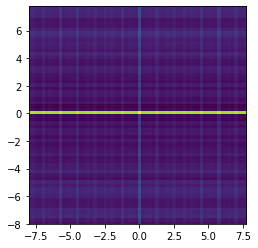

In [ ]:
imshow_field(np.log10(img.intensity))

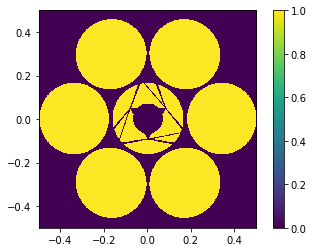

In [59]:
primary_mirror = make_gmt_aperture(normalized=True)
norm_pupil_grid = make_pupil_grid(1024)
aperture_field = primary_mirror(norm_pupil_grid)

# Scale Pupil
imshow_field(aperture_field)
plt.colorbar()

<function hcipy.aperture.realistic.make_gmt_aperture.<locals>.make_aperture(grid)>